In [39]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.pyplot as mticker

In [97]:
import numpy as np
import pandas as pd
from scipy import stats


In [41]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [42]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [43]:
engine = create_engine("sqlite:///hawaii.sqlite")

In [44]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [45]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [46]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [47]:
# Create our session (link) from Python to the DB
session = Session(engine)
# add in inspector 
inspector = inspect(engine)

# Check out tables

In [48]:
# Use inspect to set what columns are in the table
columns = inspector.get_columns('station')
for i in columns:
    print(i["name"], i["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [49]:
# check out the table in more depth
engine.execute('select * from station limit 10').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6),
 (6, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5),
 (7, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 (8, 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9),
 (9, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)]

In [50]:
#inspect the columns in the second table
columns2 = inspector.get_columns('measurement')
for i in columns2:
    print(i['name'], i['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [51]:
# check out table 2 in more depth
engine.execute('select * from measurement order by date DESC limit 10 ').fetchall()

[(2724, 'USC00519397', '2017-08-23', 0.0, 81.0),
 (7635, 'USC00514830', '2017-08-23', 0.0, 82.0),
 (12187, 'USC00519523', '2017-08-23', 0.08, 82.0),
 (19550, 'USC00516128', '2017-08-23', 0.45, 76.0),
 (2723, 'USC00519397', '2017-08-22', 0.0, 82.0),
 (12186, 'USC00519523', '2017-08-22', 0.0, 82.0),
 (19549, 'USC00516128', '2017-08-22', 0.5, 76.0),
 (2722, 'USC00519397', '2017-08-21', 0.0, 81.0),
 (7634, 'USC00514830', '2017-08-21', 0.02, 79.0),
 (12185, 'USC00519523', '2017-08-21', None, 82.0)]

# Exploratory Climate Analysis

In [52]:
#How many dates are there: 
session.query(func.count(measurement.date)).all()
# Calculate the date 1 year ago from the last data point in the database
one_year_ago = dt.date(2017,8,23) - dt.timedelta(days=365)
one_year_ago

datetime.date(2016, 8, 23)

In [53]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Perform a query to retrieve the data and precipitation scores
last12_precip = session.query(measurement.date, measurement.prcp).filter(measurement.date >= one_year_ago).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
last12_precip_df = pd.DataFrame(last12_precip)
# set date to index
last12_precip_df.set_index('date', inplace = True)

# Sort the dataframe by date
sorted_lastyear = last12_precip_df.sort_values('date')
sorted_lastyear.head(10)

,prcp
date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15
2016-08-23,0.70
2016-08-23,0.02
2016-08-24,0.08
2016-08-24,2.15


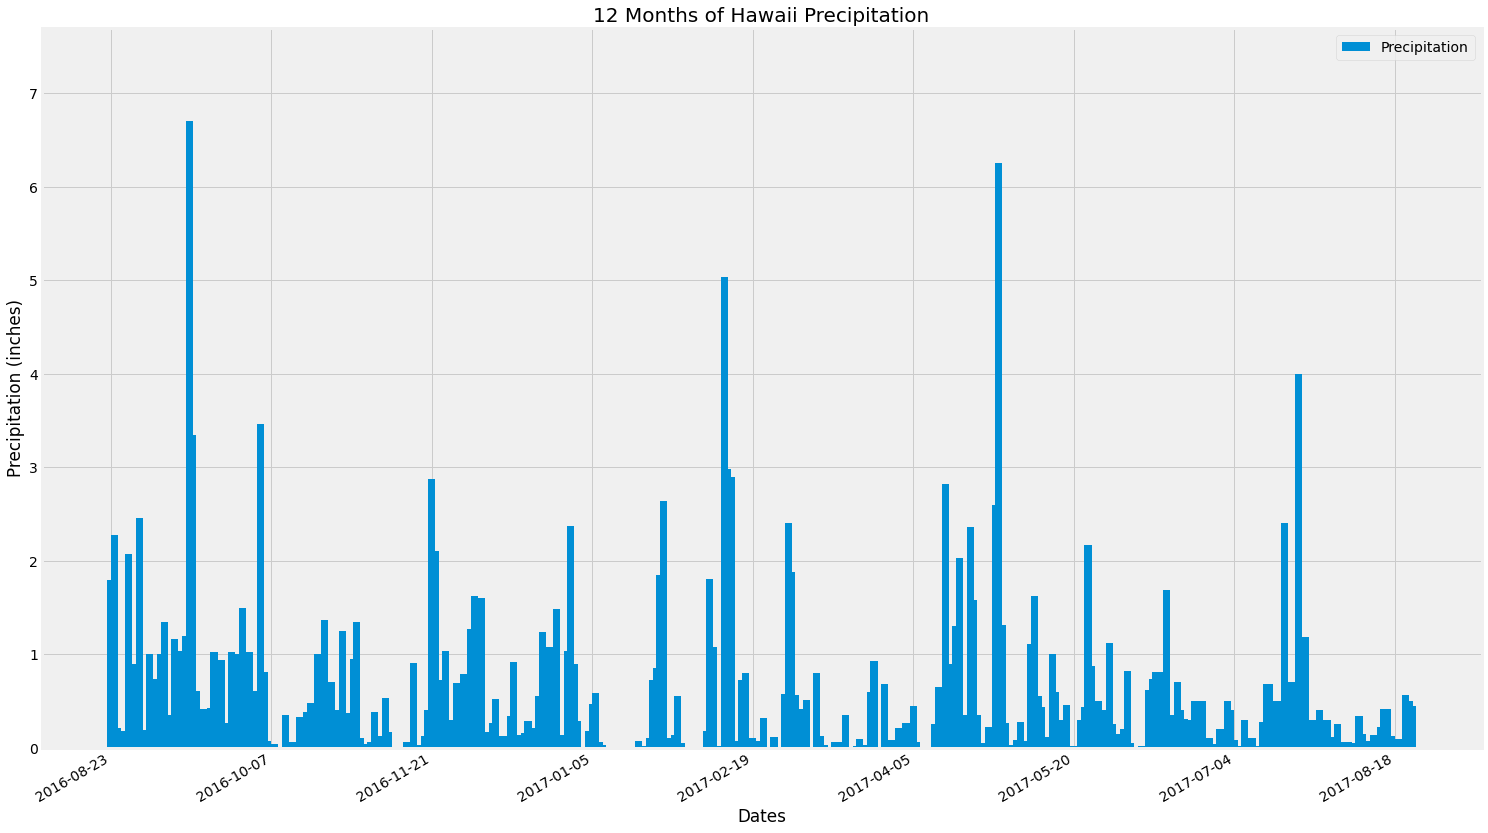

In [54]:
# Use Pandas Plotting with Matplotlib to plot the data
#set my blank slate with size:
fig = plt.figure(figsize=(20,10), facecolor = 'w') 
ax = fig.add_axes([0,0,1,1])
# set bargraph x and y axes
ax.bar(sorted_lastyear.index.values, sorted_lastyear['prcp'],width=2)
# set a y-lim
plt.ylim(0,max(sorted_lastyear['prcp']+1))
# set labels, title and legend
ax.set_xlabel('Dates')
ax.set_ylabel('Precipitation (inches)')
ax.set_title('12 Months of Hawaii Precipitation', size=20)
ax.legend(['Precipitation'], loc='best')
# format the tick labels 
fig.autofmt_xdate()
myLocator = mticker.MultipleLocator(45)
ax.xaxis.set_major_locator(myLocator)
#plot the figure
plt.show()

In [56]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_stats = sorted_lastyear.describe()
summary_stats.round(2)

,prcp
count,2021.00
mean,0.18
std,0.46
min,0.00
25%,0.00
50%,0.02
75%,0.13
max,6.70


In [57]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(measurement).group_by(measurement.station).count()
station_count

9

In [58]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_records = session.query(measurement.station, func.count(measurement.station)).\
    group_by(measurement.station).\
    order_by(func.count(measurement.station).desc()).all()
station_records
#for a,b in station_records:#the parenthesis are not required around a,b
    #print(b)

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [59]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
station_unravel = list(np.ravel(station_records))
stats = session.query(measurement.station, func.min(measurement.tobs),\
    func.max(measurement.tobs),\
    func.avg(measurement.tobs)).\
    filter_by(station = station_unravel[0]).all()
for a,b,c,d in stats:
    print(f'''=============
Station {a} has the highest number of recordings; \n\
from those recordings, the lowest temp record is {round((b),2)}\n\
the highest temp record is {round((c),2)}\n\
the average temp is {round((d),2)}'
=============''')


Station USC00519281 has the highest number of recordings; 
from those recordings, the lowest temp record is 54.0
the highest temp record is 85.0
the average temp is 71.66'


In [60]:
# Choose the station with the highest number of temperature observations.
temps = session.query(measurement.tobs,measurement.date).\
    filter(measurement.date >= one_year_ago).\
    filter_by(station = station_unravel[0]).all()

Text(0, 0.5, 'Frequency')

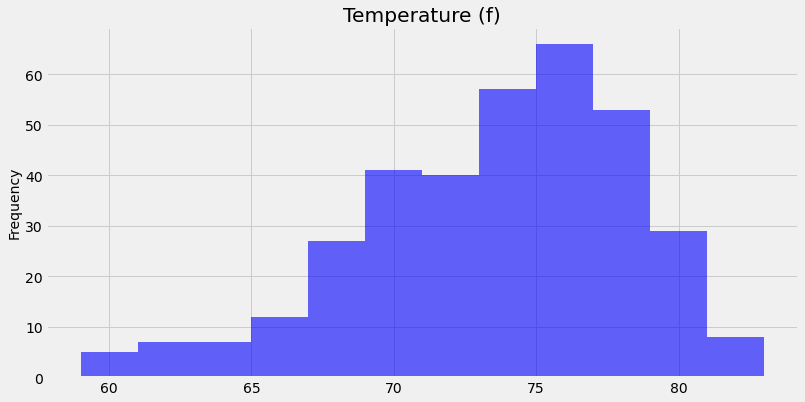

In [61]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temps12_df = pd.DataFrame(temps, columns=['Temperature (f)','Date'])
temps12_df.hist(color = 'b', alpha = .60, rwidth = 1, bins = 12, figsize = (12,6), grid = True)
plt.ylabel("Frequency", fontsize=14)

## Bonus Challenge Assignment: Other Recommended Analyses
The following are optional challenge queries. These are highly recommended to attempt, but not required for the homework.


<h3><strong>Temperature Analysis I</strong></h3>


<p><strong>Instructions:</strong> Hawaii is reputed to enjoy mild weather all year. Is there a meaningful difference between the temperature in, for example, June and December?


You may either use SQLAlchemy or pandas's read_csv() to perform this portion.


Identify the average temperature in June at all stations across all available years in the dataset. Do the same for December temperature.


Use the t-test to determine whether the difference in the means, if any, is statistically significant. Will you use a paired t-test, or an unpaired t-test? Why?</p>

<strong> My trip dates: </strong> October 28th - November 5th 2015 2015

In [83]:
#Identify the average temperature in June at all stations across all
#available years in the dataset. 
sel = [func.avg(measurement.tobs)]
all_june_temp = session.query(*sel).filter(func.strftime("%m", measurement.date) == "06").all()
#Do the same for December temperature.
all_dec_temp = session.query(*sel).filter(func.strftime("%m", measurement.date) == "12").all()

In [133]:
#Use the t-test to determine whether the difference in the means, if any, is statistically significant. 
#Will you use a paired t-test, or an unpaired t-test? Why?
#for a in 
#find June temps
j_temps=session.query(measurement.tobs)\
               .filter(func.strftime('%m',measurement.date) == '06').all()
#find Dec temps
d_temps=session.query(measurement.tobs)\
               .filter(func.strftime('%m',measurement.date) == '12').all()

#Loop through June temps and append to a list; this is similar to the baseball player activity
j_temps_list = []
for temp in j_temps:
    if type(temp.tobs) == float:
        j_temps_list.append(temp.tobs)
#loop through Dec temps and append to list
d_temps_list= []
for i in d_temps:
    if type(i.tobs) == float:
        d_temps_list.append(i.tobs)
#run a paired t-test on my lists; however, the lists are not the same length so I am going to take the first 1k.   
stats.ttest_rel(j_temps[:1000], d_temps[:1000])

Ttest_relResult(statistic=array([29.36953629]), pvalue=array([3.52245038e-137]))

<h3>Temperature Analysis II</h3>

<p><strong>Instructions:</strong> The starter notebook contains a function called calc_temps that will accept a start date and end date in the format %Y-%m-%d. The function will return the minimum, average, and maximum temperatures for that range of dates.


Use the calc_temps function to calculate the min, avg, and max temperatures for your trip using the matching dates from the previous year (i.e., use "2017-01-01" if your trip start date was "2018-01-01").


Plot the min, avg, and max temperature from your previous query as a bar chart.


Use the average temperature as the bar height.


Use the peak-to-peak (TMAX-TMIN) value as the y error bar (YERR).</p>

In [25]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    return session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
        filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [26]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

start_date = dt.date(2015,10,28)
end_date = start_date + dt.timedelta(days=8)

last_year_start = start_date - dt.timedelta(days=365)
last_year_end = end_date - dt.timedelta(days=365)

last_year_temps = calc_temps(last_year_start, last_year_end)
unpacked_last = list(np.ravel(last_year_temps))
unpacked_last

[68.0, 75.64516129032258, 81.0]

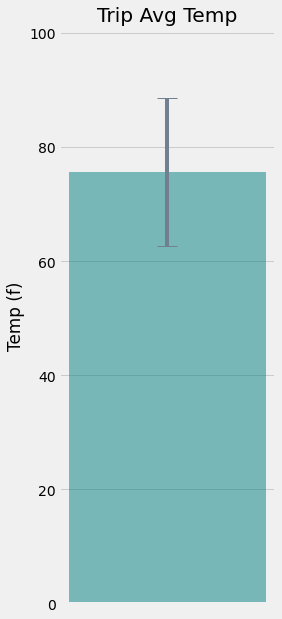

In [27]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
min_temp = unpacked_last[0]
avg_temp = unpacked_last[1]
max_temp = unpacked_last[2]
x_axis = np.arange(0)
fig = plt.figure(figsize=(3,8),edgecolor= 'k')
ax = fig.add_axes([0,0,1,1])
ax.set_xticks(x_axis)
ax.set_ylabel("Temp (f)")
ax.set_title("Trip Avg Temp")
plt.ylim(0,max_temp+20)
ax.bar(0,avg_temp, yerr=max_temp-min_temp, align='center', alpha=0.5, ecolor='slategrey', capsize=10,\
       color = 'teal')
plt.show()

# Daily Rainfall Average

In [28]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
sel = [station.station, station.name, station.latitude, station.longitude, station.elevation,\
       func.sum(measurement.prcp)]

join_station = session.query(*sel).filter(measurement.station == station.station).\
                    group_by(measurement.station).\
                    order_by(func.sum(measurement.prcp).desc()).all()
join_station

[('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  1068.0899999999997),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  588.6400000000001),
 ('USC00513117',
  'KANEOHE 838.1, HI US',
  21.4234,
  -157.8015,
  14.6,
  382.6199999999998),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  295.6800000000001),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  234.49000000000007),
 ('USC00519397',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0,
  131.61999999999992),
 ('USC00511918',
  'HONOLULU OBSERVATORY 702.2, HI US',
  21.3152,
  -157.9992,
  0.9,
  92.67999999999995),
 ('USC00518838',
  'UPPER WAHIAWA 874.3, HI US',
  21.4992,
  -158.0111,
  306.6,
  70.86999999999999),
 ('USC00517948',
  'PEARL CITY, HI US',
  21.3934,
  -157.9751,
  11.9,
  43.43999999999998)]

In [29]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [30]:
# My trip:2014-10-28 - 2014-11-5


# Set the start and end date of the trip
# Use the start and end date to create a range of dates
vac_range = session.query(measurement.date).\
    filter(measurement.date >= start_date).\
    filter(measurement.date <= end_date).\
    group_by(measurement.date).all()
# calculate the daily normals for your trip
normals = list(np.ravel(vac_range))
# Strip off the year and save a list of %m-%d strings
# push each tuple of calculations into a list called `normals`
hack = [d[-5:] for d in normals]
# Loop through the list of %m-%d strings and calculate the normals for each date
range_list = []
m_list = []
for i in hack:
    range_list.append(daily_normals(i)[0])
looped_list = list(np.ravel(range_list))
min_list = looped_list[::3]
avg_list = looped_list[1::3]
max_list = looped_list[2::3]


In [31]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
new_df = pd.DataFrame({'Date':hack,'Min Temps':min_list, "Avg Temp": avg_list, 'Max Temp': max_list})
new_df.set_index('Date', inplace=True)
new_df

,Min Temps,Avg Temp,Max Temp
Date,,,
10-28,68.0,74.754717,82.0
10-29,68.0,74.886792,81.0
10-30,64.0,74.660000,81.0
10-31,67.0,74.836735,80.0
11-01,65.0,74.862745,83.0
11-02,64.0,74.062500,81.0
11-03,66.0,74.959184,82.0
11-04,65.0,74.075472,82.0
11-05,64.0,73.557692,78.0


Text(0, 0.5, 'Temperature (f)')

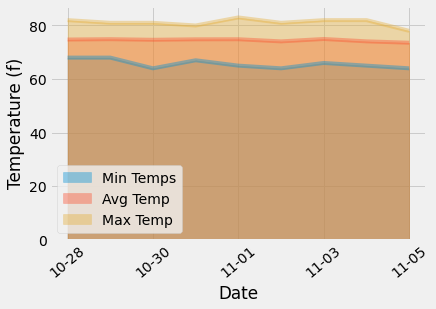

In [32]:
# Plot the daily normals as an area plot with `stacked=False`
#fig = plt.figure(figsize=(10,8))
ax = new_df.plot.area(stacked=False, rot=40, alpha = .4)
ax.set_ylabel("Temperature (f)")